# 函数

In [18]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import seaborn as sns
import tensorflow as tf
from sklearn import svm
from subprocess import call
from scipy import signal
from sklearn import tree
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import numpy as np
import warnings
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate
from numpy import array
from WindPy import w
w.start()

#激活函数及坡度
def sig(x):
    return 1 / (1 + exp(-x))

def sig_drv(x):
    return x * (1-x)

#生成初始神经网络
def gen_layer(x,y,nnum):
    res = [2 * random.random((len(x[0]), nnum[0])) - 1]
    if len(nnum) > 1:
        for i in range(1,len(nnum)):
            res.append(2 * random.random((nnum[i-1], nnum[i])) - 1)
    res.append(2 * random.random((nnum[-1], len(y[0]))) - 1)
    return res

#输入结果
def calc(x, nn):
    res = []
    for i in range(len(nn)):
        if i == 0:
            res.append(sig(dot(x, nn[i])))
        else:
            res.append(sig(dot(res[-1], nn[i])))
    return res

#纠正
def correct(x, y, nnum, time,prt):
    layer = gen_layer(x,y,nnum)
    for j in range(time):
        res = calc(x, layer)
        det = []
        err = []
        adj = []
        for i in range(len(layer)-1,-1,-1):
            if i == len(layer)-1:
                err.append(y - res[-1])
                det.append(err[0] * sig_drv(res[-1]))
            else:
                err.append(det[-1].dot((layer[i+1]).T))
                det.append(err[-1] * sig_drv(res[i]))
        
        det = det[::-1]
        for i in range(len(det)):
            if i == 0:
                adj.append((x.T).dot(det[i]))
            else:
                adj.append((res[i-1].T).dot(det[i]))        
        for i in range(len(layer)):
            layer[i] += adj[i]
    if prt:
        print(layer)
    return layer

#去春节影响
def spring(data, date):
    res = []
    for i in range(len(data)):
        if date[i].month == 1 and i < len(date)-1:
            temp = deepcopy(data[i]+data[i+1])/2
            res.append(temp)
            res.append(temp)
        elif date[i].month == 2:
            continue
        else:
            res.append(data[i])
    return res

def und(dat, l1, l2):
    i = 0
    res = [0] * len(dat)

    while i < len(dat)-1:
        if i + l1 >= len(dat) - 1 - l2:
            for j in range(i, len(dat)-l2):
                res[j] = res[i]
            break
        cur = dat[i]
        next_id = min([(dat[i+1:]).index(max(dat[i+1+l1:i+1+l2])), (dat[i+1:]).index(min(dat[i+1+l1:i+1+l2]))]) +i+1
        res[i:next_id+1] = [- (-1) ** (dat[next_id] > dat[i])] * (next_id + 1 - i)
        i = next_id
    return res

#波峰过滤
def peak(data):
    res = [0]
    for i in range(1, len(data)-1):
        if data[i-1] < data[i] > data[i+1]:
            res.append(data[i])
        else:
            res.append(0)
    res.append(0)
    return res

#波谷过滤
def bot(data):
    res = [0]
    for i in range(1, len(data)-1):
        if data[i-1] > data[i] < data[i+1]:
            res.append(data[i])
        else:
            res.append(0)
    res.append(0)
    return res

#清理重复的月份
def date_clean(date,data):
    date_res = [date[0]]
    data_res = [[i[0]] for i in data]
    
    last = date[0]
    
    for i in range(len(date[1:])):
        cur = date[i]
        if cur.month != last.month:
            date_res.append(cur)
            for j in range(len(data_res)):
                data_res[j].append(data[j][i])
        last = date[i]

    return date_res, data_res

#时间序列模型预测
def ts_predict(data, date, n_steps):
    
    f, err95, ci95 = best_mdl.forecast(steps=n_steps)
    idx = [date[-1]]
    for i in range(n_steps-1):
        idx.append(next_month(idx[-1]))
    fc_all = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
    return fc_all['forecast'][1]

#移动平均线MA
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x]/d1[i1-x-l_roc]-1)/l_sma
    return res

#KST公式
def kst(d2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    res = []
    for i in range(roc_l4+sma_l4, len(d2)):
        rocma1 = rocsma(d2,i,roc_l1,sma_l1)
        rocma2 = rocsma(d2,i,roc_l2,sma_l2)
        rocma3 = rocsma(d2,i,roc_l3,sma_l3)
        rocma4 = rocsma(d2,i,roc_l4,sma_l4)
        res.append(rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    return res
    
#斜率
def slope(data):
    res = [0]
    for i in range(1,len(data)):
        res.append(-(-1) ** (data[i]>data[i-1]))
    res[0] = res[1]
    return res
    
#获取下个月末
def next_month(date):
    if date.month == 12:
        res = date.replace(year = date.year + 1, month = 1, day = calendar.monthrange(int(date.year+1), 1)[1])
        
    else:
        res = date.replace(month = date.month + 1, day = calendar.monthrange(int(date.year), date.month + 1)[1])
        
    return res

#相对强度
def rel_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

#训练与验证集
def trvd(x, y, ratio):
    train_x = x[:int(len(x)*ratio)]
    valid_x = x[int(len(x)*ratio):]
    train_y = y[:int(len(x)*ratio)]
    valid_y = y[int(len(x)*ratio):]
    
    print(len(train_x), len(valid_x), len(train_y), len(valid_y))
    return train_x, valid_x, train_y, valid_y

#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#大小对比
def comp(d1,d2):
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#标准化
def std(data):
    res = []
    for i in range(len(data)):
        res.append((data[i] - np.mean(data[:i+1]))/np.mean(data[:i+1]))
    return res

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

#相关性
def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b)
 
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
 
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b]))

    corr_factor = cov_ab/sq
 
    return corr_factor


def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data

def l2n0(data):
    res = []
    for i in range(len(data)):
        if data[::-1][i] != 0:
            res.append(data[::-1][i])
        if len(res) == 2:
            break
    return res[0]/res[1]-1

def date2num(date):
    d8 = []
    for i in range(len(date)):
        d8.append(int((date[i] - date[0]).days))
    return d8
    
def find1y(date):
    last = date[0]
    for i in range(len(date)):
        cur = date[i]
        if cur.year != last.year:
            return i
        last = date[i]
######################################评估方式

#准确度计算
def acc(res,ans):
    if len(res) == len(ans):
        return round(sum(np.array(res) == np.array(ans))/ len(res),2)
    else:
        print('时间长度不同')

#收益率计算
def profit(data, ud):
    if len(data) != len(ud):
        print('长度不一')
    money = 1
    num = 0
    prt = 0   #显示买卖记录
    m2y = 1   #是否年化收益
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
 
            num = money/(data[i]+10e-6)
            money = 0
        if ud[i] == -1 and money == 0 and data[i] != 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print('结果',money+num*data[-1])
    if m2y:
        return (money+num*data[-1]) ** (1/len(data)*12)
    return money+num*data[-1]

#错误区间占比
def wrong_div(dat, ud):
    c_div = 1
    c_wrong = 0
    l_wrong = 1
    l_all = 0
    dirc = ud[0]
    last = dat[0]
    for i in range(1,len(dat)):
        l_wrong += 1
        if ud[i] == 0:
            return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(dat))
        if ud[i] != dirc:
            c_div += 1
            if -(-1)**(dat[i] > last) != dirc:
                c_wrong += 1
                l_all += l_wrong
            l_wrong = 1
            last = dat[i]
            dirc = ud[i]
            
    return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(data))
#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)

def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正态分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return
random.seed(1)

# 读取数据

In [2]:
D = (pd.read_excel('nh_w.xls',index_col=0)).fillna(0)
D

,南华综合指数:周
指标名称,
2004-06-05,990.2740
2004-06-12,971.2214
2004-06-19,992.8425
2004-06-26,1007.0781
2004-07-03,1009.7499
...,...
2020-10-10,1470.4700
2020-10-17,1476.4600
2020-10-24,1470.9000


In [3]:
def data_pro(data,l):
    
    df = []
    
    #从第l个周期开始
    for i in range(l-1,len(date)):
        temp = []

        for j in range(len(data)):
            i = int(i)
            j = int(j)
            
            #选取第j组数据
            il = data[j][i-l+1:i+1]
            
            #价格与移动平均线的关系 7
            temp.append(-(-1) ** (data[j][i] >= np.mean(il)))    
            
            #ROC 0~3
            temp.append(il[-1]/(il[-2]+10e-4)-1)
            temp.append(il[-1]/(il[-4]+10e-4)-1)
            temp.append(il[-1]/(il[-7]+10e-4)-1)
            temp.append(il[-1]/(il[0]+10e-4)-1)
            
            #极值差距 4
            temp.append(((max(il)-min(il))/np.mean(il)))
            
            #反转频率 5
            spike = 0
            dirc = -(-1) ** (il[1] > il[0]) 
            for k in range(1,l):
                spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
                dirc = -(-1) ** (il[k] > il[k-1])
            temp.append(spike)
            
            #当前指数 6
            temp.append(il[-1]/np.mean(il[6:])-1)
            
        df.append(temp)
    return df

指数数量 1
时间长度 837
处理后数据范围 11 ~ 837
趋势判断范围 0 ~ 794


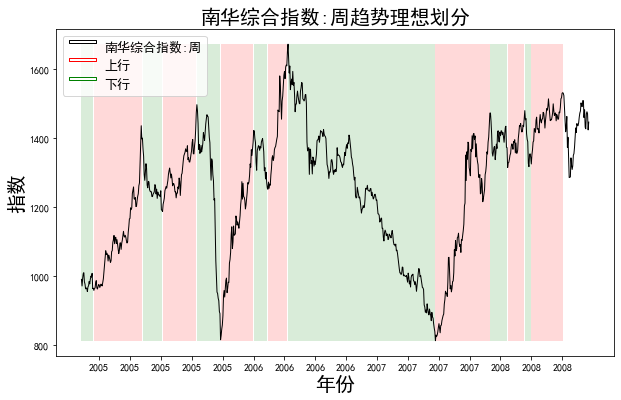

In [4]:
#提取日期与时间
date = D.index
data = np.array(D).T

#每段数据长度l
l = 12

#加工日期与时间
d8 = date2num(date)
df = data_pro(data,l)
#结果计数
c = 0
name = []
L = int(len(df[0])/len(data))
lag = 50
start = 100

#单组数据
ud=und(list(data[0]),10,lag)

#总结
print('指数数量',len(data))
print('时间长度',len(date))
print('处理后数据范围',l-1,'~',len(df)+l-1)
print('趋势判断范围',0,'~',len(ud[:ud.index(0)]))

#理想划分
ii = 0
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title(list(D)[ii]+'趋势理想划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
d8, ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
d8, ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

exec('bp = profit(data['+str(ii)+'],ud)')
exec('bc = cpx(ud)')

plt.show()

# 移动平均线（参照）

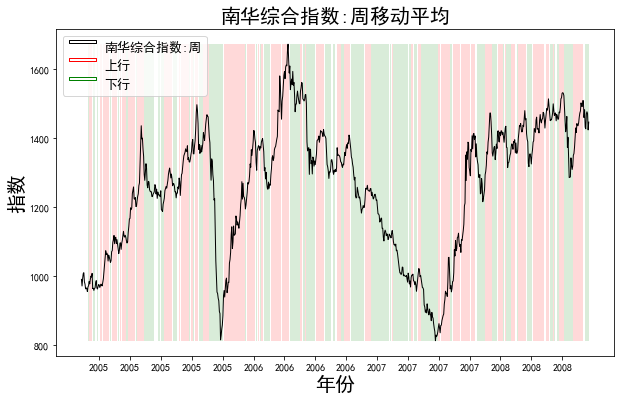

南华综合指数:周 准确率 71.0 %
南华综合指数:周 复杂度 8.31
南华综合指数:周 年化收益率 1.15 %


In [5]:
ii = 0
data_ma = ma(data[ii],12)
ud_ma = comp(data[ii][11:],data_ma)

l_ma = len(date) - len(ud_ma)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title(list(D)[ii]+'移动平均',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
d8[l_ma:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
d8[l_ma:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1
exec('a' + str(c) + '= 100*acc(ud_ma[:len(ud[l-1:ud.index(0)])],ud[l-1:ud.index(0)])')
exec('c' + str(c) + '= round(cpx(ud_ma)/bc,2)')
exec('p' + str(c) + '= round((profit(data[0][-len(ud_ma):], ud_ma)-1)*100,2)')

print(list(D)[ii],'准确率', eval('a'+str(c)),'%')
print(list(D)[ii],'复杂度', eval('c'+str(c)))
print(list(D)[ii],'年化收益率', eval('p'+str(c)),'%')

name.append('移动平均'+list(D)[ii])

# 逻辑回归

In [6]:
ii = 0
X = [i[ii*L:(ii+1)*L] for i in df[:-lag]]
y = ud[11:-lag]
lm = LinearRegression()
lm.fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
print(myDF3)

   Coefficients  Standard Errors  t values  Probabilites
0       -0.2628            0.137    -1.913         0.056
1        0.1939            0.045     4.263         0.000
2        1.0040            2.469     0.407         0.684
3       -0.1226            2.957    -0.041         0.967
4        0.6129            1.526     0.402         0.688
5        2.5344            0.661     3.832         0.000
6        2.8899            0.623     4.637         0.000
7       -0.0053            0.023    -0.236         0.814
8        3.3358            5.997     0.556         0.578


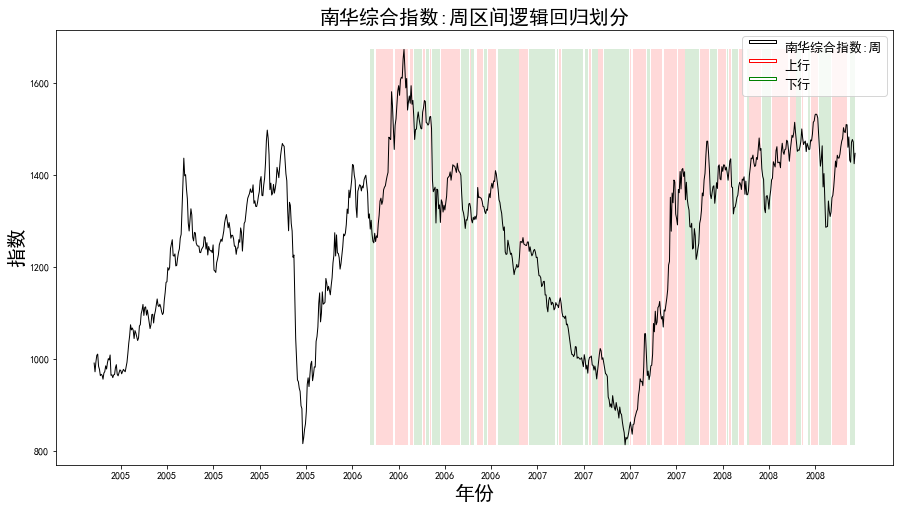

南华综合指数:周 准确率 67.0 %
南华综合指数:周 复杂度 7.59
南华综合指数:周 年化收益率 1.05 %


In [7]:
logr = LogisticRegression()
ii = 0
data_bond = [i[ii*L:(ii+1)*L] for i in df]

logr_prd = []
for i in range(start*3,len(date)):
    cur_ud = und(list(data[ii])[:i],10,lag)
    logr.fit(data_bond[:i-lag-11], cur_ud[11:-lag])
    logr_prd.append(int(((-(-1)**(logr.predict([data_bond[i-11]]) >= 0)))))
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(list(D)[ii]+'区间逻辑回归划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_logr = len(d8) - len(logr_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_logr:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(logr_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_logr:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(logr_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('a' + str(c) + '= 100*acc(logr_prd[:-50],ud[300:-50])')
exec('c' + str(c) + '= round(cpx(logr_prd)/bc,2)')
exec('p' + str(c) + '= round((profit(data[0][-len(logr_prd):], logr_prd)-1)*100,2)')

print(list(D)[ii],'准确率', eval('a'+str(c)),'%')
print(list(D)[ii],'复杂度', eval('c'+str(c)))
print(list(D)[ii],'年化收益率', eval('p'+str(c)),'%')

name.append('log'+list(D)[ii])

# 决策树

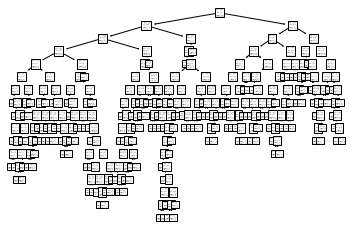

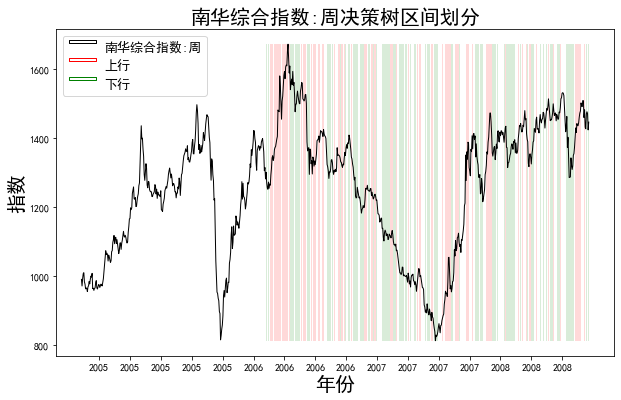

南华综合指数:周 准确率 56.00000000000001 %
南华综合指数:周 复杂度 20.05
南华综合指数:周 年化收益率 -0.33 %


In [8]:
tr = DecisionTreeClassifier()

data_bond = [i[ii*L:(ii+1)*L] for i in df]

tr_prd = []
for i in range(start*3,len(date)):
    cur_ud = und(list(data[ii])[:i],10,lag)
    tr.fit(data_bond[:i-lag-11], cur_ud[11:-lag])
    tr_prd.append(int(((-(-1)**(tr.predict([data_bond[i-11]])[0] >= 0)))))
tree.plot_tree(tr)
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title(list(D)[ii]+'决策树区间划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_tr = len(d8) - len(tr_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_tr:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(tr_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_tr:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(tr_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('a' + str(c) + '= 100*acc(tr_prd[:-50],ud['+str(start*3)+':-50])')
exec('c' + str(c) + '= round(cpx(tr_prd)/bc,2)')
exec('p' + str(c) + '= round((profit(data[0][-len(tr_prd):], tr_prd)-1)*100,2)')

print(list(D)[ii],'准确率', eval('a'+str(c)),'%')
print(list(D)[ii],'复杂度', eval('c'+str(c)))
print(list(D)[ii],'年化收益率', eval('p'+str(c)),'%')

name.append('决策树'+list(D)[ii])

# 随机森林

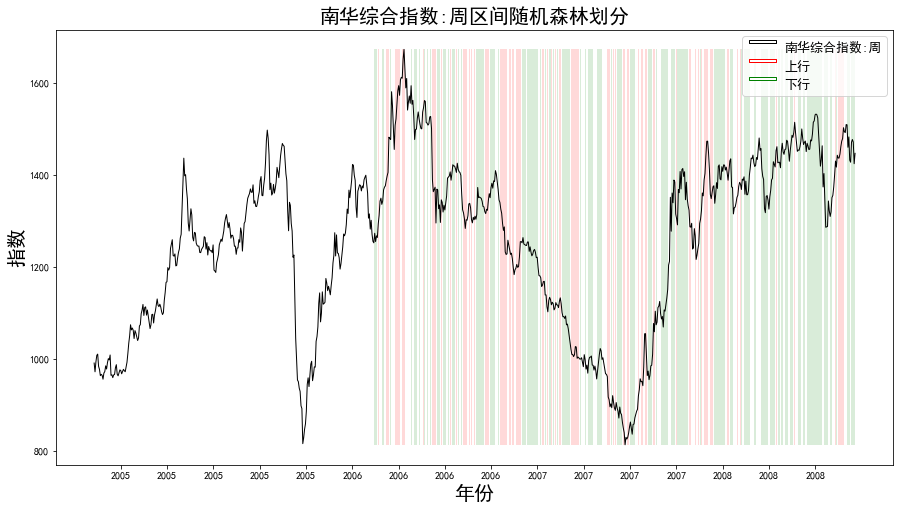

南华综合指数:周 准确率 16.0 %
南华综合指数:周 复杂度 20.68
南华综合指数:周 年化收益率 0.24 %


In [9]:
ii = 0
data_bond = [i[ii*L:(ii+1)*L] for i in df]

rf_prd = []
rf = RandomForestRegressor(n_estimators = 5)
for i in range(start*3,len(date)):
    cur_ud = und(list(data[ii])[:i],10,lag)
    rf.fit(data_bond[:i-lag-11], cur_ud[11:-lag])
    rf_prd.append(int(((-(-1)**(rf.predict([data_bond[i-11]])) >= 0))))
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(list(D)[ii]+'区间随机森林划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_rf = len(d8) - len(rf_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('a' + str(c) + '= 100*acc(rf_prd[:-50],ud[300:-50])')
exec('c' + str(c) + '= round(cpx(rf_prd)/bc,2)')
exec('p' + str(c) + '= round((profit(data[0][-len(rf_prd):], rf_prd)-1)*100,2)')

print(list(D)[ii],'准确率', eval('a'+str(c)),'%')
print(list(D)[ii],'复杂度', eval('c'+str(c)))
print(list(D)[ii],'年化收益率', eval('p'+str(c)),'%')

name.append('随机森林'+list(D)[ii])

# 神经网络

# 支持向量机

## 多项式

In [ ]:
mod_svm = svm.SVC(C=10, kernel='poly') 
ii = 0
data_bond = [i[ii*L:(ii+1)*L] for i in df]
svm_prd = []
for i in range(start*3,len(date)):
    cur_ud = und(list(data[ii])[:i],10,50)
    mod_svm.fit(data_bond[:i-50-11], cur_ud[11:-50])
    svm_prd.append(((-(-1)**   ((mod_svm.predict([data_bond[i-11]])) >= 0 )[0]   )))
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(list(D)[ii]+'区间划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_svm = len(d8) - len(svm_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_svm:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(svm_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_svm:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(svm_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('a' + str(c) + '= 100*acc(svm_prd[:-50],ud[300:-50])')
exec('c' + str(c) + '= round(cpx(svm_prd)/bc,2)')
exec('p' + str(c) + '= round((profit(data[0][-len(svm_prd):], svm_prd)-1)*100,2)')

print(list(D)[ii],'准确率', eval('a'+str(c)),'%')
print(list(D)[ii],'复杂度', eval('c'+str(c)))
print(list(D)[ii],'年化收益率', eval('p'+str(c)),'%')

name.append('SVM多项式'+list(D)[ii])

## 线性

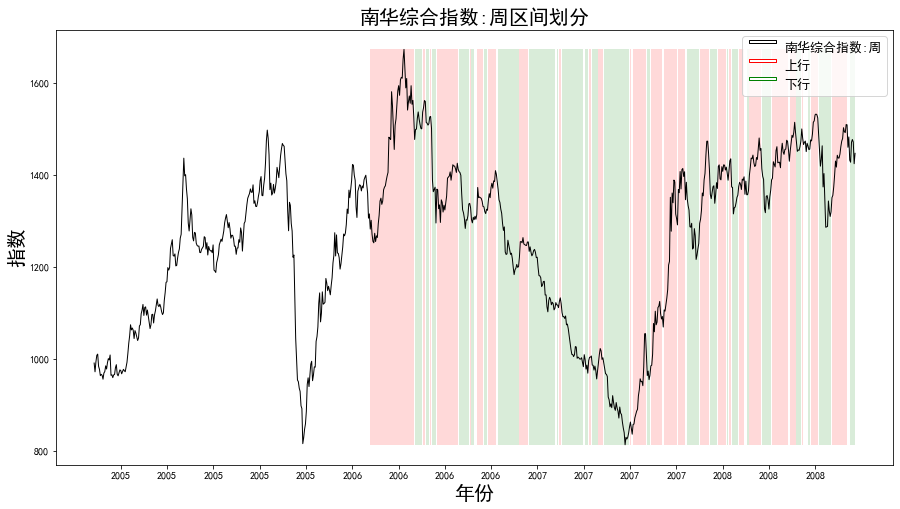

南华综合指数:周 准确率 66.0 %
南华综合指数:周 复杂度 7.07
南华综合指数:周 年化收益率 0.96 %


In [31]:
mod_svm = svm.SVC(kernel='linear')
ii = 0
data_bond = [i[ii*L:(ii+1)*L] for i in df]
svm_prd = []
for i in range(start*3,len(date)):
    cur_ud = und(list(data[ii])[:i+1],6,lag)
    mod_svm.fit(data_bond[:i-lag-11], cur_ud[12:-lag])
    svm_prd.append((mod_svm.predict([data_bond[i-11]]  ) [0] ))

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(list(D)[ii]+'区间划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_svm = len(d8) - len(svm_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_svm:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(svm_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_svm:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(svm_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('a' + str(c) + '= 100*acc(svm_prd[:-50],ud[300:-50])')
exec('c' + str(c) + '= round(cpx(svm_prd)/bc,2)')
exec('p' + str(c) + '= round((profit(data[0][-len(svm_prd):], svm_prd)-1)*100,2)')

print(list(D)[ii],'准确率', eval('a'+str(c)),'%')
print(list(D)[ii],'复杂度', eval('c'+str(c)))
print(list(D)[ii],'年化收益率', eval('p'+str(c)),'%')

name.append('SVM线性'+list(D)[ii])

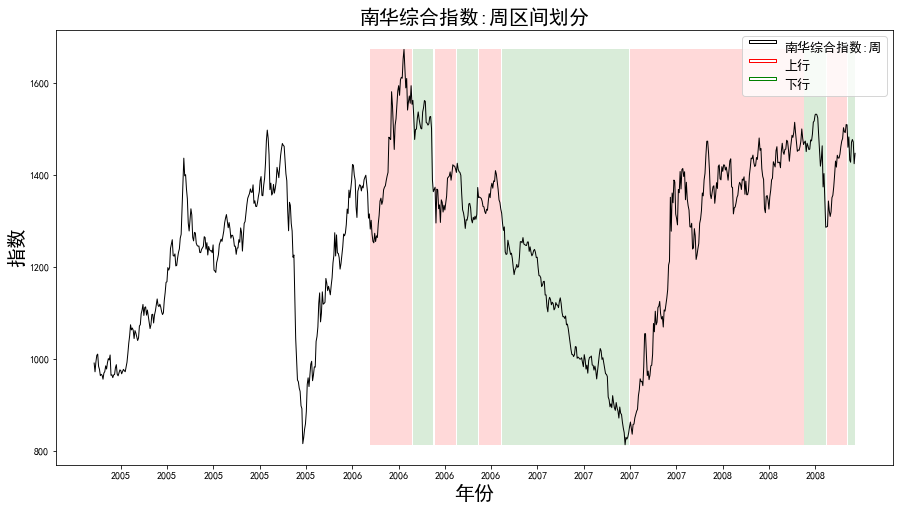

南华综合指数:周 准确率 77.0 %
南华综合指数:周 复杂度 1.04
南华综合指数:周 单位时间收益率 1.99 %


In [30]:
svm_res = []

step = 24
for i in range(0, len(svm_prd), step):
    if i+step >= (len(svm_prd) - 1):
        svm_res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*(len(svm_prd)-i)
        break
    else:
        svm_res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*step

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(list(D)[ii]+'区间划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_svm = len(d8) - len(svm_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_svm:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(svm_res) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_svm:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(svm_res) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

exec('a' + str(c) + '= 100*acc(svm_res[:-50],ud[:-50][-len(svm_res[:-50]):])')
exec('c' + str(c) + '= round(cpx(svm_res)/bc,2)')
exec('p' + str(c) + '= round((profit(data[0][-len(svm_res):], svm_res)-1)*100,2)')

print(list(D)[ii],'准确率', eval('a'+str(c)),'%')
print(list(D)[ii],'复杂度', eval('c'+str(c)))
print(list(D)[ii],'单位时间收益率', eval('p'+str(c)),'%')

## 高斯

In [ ]:
mod_svm = svm.SVC(C=1.0,kernel='rbf')

data_bond = [i[ii*L:(ii+1)*L] for i in df]
svm_prd = []
for i in range(start*3,len(date)):
    cur_ud = und(list(data[ii])[:i],6,lag)
    mod_svm.fit(data_bond[:i-lag-11], cur_ud[11:-lag])
    svm_prd.append(((-(-1)**   ((mod_svm.predict([data_bond[i-11]])) >= 0 )[0]   )))
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(list(D)[ii]+'区间划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(D)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_svm = len(d8) - len(svm_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_svm:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(svm_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_svm:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(svm_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('a' + str(c) + '= 100*acc(svm_prd[:-50],ud[300:-50])')
exec('c' + str(c) + '= round(cpx(svm_prd)/bc,2)')
exec('p' + str(c) + '= round((profit(data[0][-len(svm_prd):], svm_prd)-1)*100,2)')

print(list(D)[ii],'准确率', eval('a'+str(c)),'%')
print(list(D)[ii],'复杂度', eval('c'+str(c)))
print(list(D)[ii],'年化收益率', eval('p'+str(c)),'%')

name.append('SVM高斯'+list(D)[ii])

# 总结

In [ ]:
name.append('平均值')
name.append('中位数')

In [ ]:
final_result = []
for i in range(1,c+1):
    final_result.append([eval('a'+str(i)), eval('c'+str(i)), eval('p'+str(i))])
final_result.append([round(np.mean([i[0] for i in final_result]),2),np.mean([i[1] for i in final_result]),np.mean([i[2] for i in final_result])])
final_result.append([round(np.median([i[0] for i in final_result]),2),np.median([i[1] for i in final_result]),
                     np.median([i[2] for i in final_result])])

for i in range(len(final_result)):
    for j in range(len(final_result[0])):
        if j != 4:
            if j == 0:
                final_result[i][j] = str(final_result[i][j])+'%'
            else:
                final_result[i][j] = round(final_result[i][j],2)
table = pd.DataFrame(final_result, 
            index = name
        ,columns=['准确度', '复杂度', '年化收益'])
table